In [1]:
%env CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8
import warnings
warnings.filterwarnings("ignore", message=".*`torch.cuda.amp.autocast.*")

import torch
import torch.nn.functional as F
import numpy as np
import random
import math
from types import SimpleNamespace
from datasets import load_dataset
from timm.optim import Adan
from torchvision.transforms import InterpolationMode
from torchvision.transforms.v2 import (
    Compose, RandAugment, RandomErasing, Resize, RandomCrop, CenterCrop, 
    PILToTensor, ConvertImageDtype, MixUp, CutMix, ToPILImage
)
from fastprogress.fastprogress import master_bar, progress_bar
import copy
import PIL

env: CUDA_VISIBLE_DEVICES=MIG-768d9c1d-110f-52e2-b0a2-3252f78280f8


In [2]:
torch.set_float32_matmul_precision('highest')

########################################################
# 1. CONFIG & HYPERPARAMS
########################################################
config = SimpleNamespace()

# Basic training
config.epochs = 20
config.batch_size = 128
config.num_workers = 8
config.grad_accum_steps = 1
config.max_lr = 2e-2  # single-cycle maximum LR
config.lr_pow = 1.0

# Weight decay, ignoring norm/bias
config.weight_decay = 0.1
config.no_wd_keys = ['norm', 'bias']

# Data augmentation
config.randaug_n = 2
config.randaug_m = 5
config.randerase = 0.2

# Progressive resizing: 4 stages over 20 epochs => [0..4] ->128, [5..9]->160, [10..14]->192, [15..19]->224
config.progressive_resize = True
config.progressive_sizes = [128, 160, 192, 224]
config.rrc = True  # If True, random resize approach (like RRC) instead of fixed resize+crop

# Mixup & CutMix
config.mixup_alpha = 0.2
config.cutmix_alpha = 0.2

# Label smoothing
config.label_smoothing = 0.1

# MESA / EMA teacher-student
config.mesa = True
config.mesa_ratio = 2.0
config.mesa_start = 0.25  # fraction of training after which we add MESA loss

# We'll keep 20 epochs, single-cycle LR, Adan, etc.
seed = 42
device = "cuda:0"


########################################################
# 2. DATASETS
########################################################
dataset_train = load_dataset('timm/imagenet-1k-wds', split='train')
dataset_valid = load_dataset('timm/imagenet-1k-wds', split='validation')
num_train = dataset_train.num_rows
num_valid = dataset_valid.num_rows

steps_per_epoch = num_train // config.batch_size
total_steps = config.epochs * steps_per_epoch

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

print("Train samples:", num_train, "Valid samples:", num_valid)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/292 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/64 [00:00<?, ?it/s]

Train samples: 1281167 Valid samples: 50000


In [3]:
from timm.models.efficientvit_mit import EfficientVitLarge, GELUTanh

def create_model():
    """Create an EfficientVitLarge w/ optional dropout / drop_path."""

    class GroupNorm8(torch.nn.Module):
        def __init__(self, num_features, eps=1e-5, affine=True):
            super().__init__()
            self.gn = torch.nn.GroupNorm(num_groups=8, num_channels=num_features, eps=eps, affine=affine)
        def forward(self, x):
            return self.gn(x)

    model = EfficientVitLarge(
        in_chans=3,
        widths=(32, 64, 128, 256, 512),
        depths=(1, 1, 1, 6, 6),
        head_dim=32,
        norm_layer=GroupNorm8,
        act_layer=GELUTanh,
        global_pool='avg',
        head_widths=(3072, 3200),
        num_classes=1000
    )
    # Replace final norm if needed
    if hasattr(model, 'head') and hasattr(model.head, 'in_conv'):
        if hasattr(model.head.in_conv, 'norm'):
            old = model.head.in_conv.norm
            model.head.in_conv.norm = GroupNorm8(
                num_features=old.num_features,
                eps=old.eps,
                affine=old.affine
            )
    return model

model = create_model().to(device)
print(f"Model param count: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

Model param count: 52.65M


In [4]:
class EMAHelper:
    def __init__(self, model, decay=0.9999):
        self.decay = decay
        self.teacher = copy.deepcopy(model)
        for p in self.teacher.parameters():
            p.requires_grad_(False)

    def update(self, student):
        with torch.no_grad():
            d = self.decay
            for tparam, sparam in zip(self.teacher.parameters(), student.parameters()):
                tparam.copy_(tparam * d + sparam * (1 - d))
    
    def forward(self, x):
        return self.teacher(x)

In [5]:
param_groups = []
for name, p in model.named_parameters():
    if p.requires_grad:
        use_wd = True
        for kw in config.no_wd_keys:
            if kw in name.lower():
                use_wd = False
                break
        wd_val = config.weight_decay if use_wd else 0.0
        param_groups.append({'params': [p], 'weight_decay': wd_val})

optimizer = Adan(param_groups, lr=1.0, weight_decay=0.0, caution=True)

def one_cycle_cosine(step):
    # Single-cycle cosine from 0 -> max_lr -> 0 over total_steps
    t = step / (total_steps - 1)
    t = t**config.lr_pow
    lr = 0.5 * (1.0 - math.cos(2.0 * math.pi * t)) * config.max_lr + 1e-15
    return lr

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=lambda s: one_cycle_cosine(s)
)

In [6]:
def random_interpolation():
    choices = [InterpolationMode.BILINEAR, InterpolationMode.BICUBIC, InterpolationMode.LANCZOS]
    return random.choice(choices)

def get_epoch_size(epoch):
    if not config.progressive_resize:
        return config.progressive_sizes[-1]
    # For example, 5 epochs each stage:
    stage_len = config.epochs // len(config.progressive_sizes)
    idx = min(epoch // stage_len, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]


def build_train_prebatch_transform(epoch):
    """
    Returns a transform that does:
      1) Resize or random-resized-crop
      2) RandAug + random erasing
      3) Convert to float => scale to [-1,1]

    We do all of this per-sample (not on an entire batch at once).
    """
    img_size = get_epoch_size(epoch)

    # For a true "RandomResizedCrop w/ random interpolation" you'd typically do something like:
    # transforms.RandomResizedCrop(img_size, scale=(0.08,1.0), ratio=(0.75,1.3333), interpolation= ...)
    # but torchvision.transforms.v2 doesn't provide a direct "random interpolation" argument. We'll hack it:
    # We'll just choose an interpolation for the entire epoch, or you could do it per-sample with a custom class.
    interp = random_interpolation()

    if config.rrc:
        # We'll do a naive approach: resize to (img_size, img_size) for demonstration
        # If you want the actual 'random crop of various scales', you'd do something else
        resize_op = Resize((img_size, img_size), interpolation=interp)
    else:
        # normal "resize short edge to img_size + randomcrop"
        # for simplicity, let's do a direct approach
        resize_op = Compose([
            Resize(img_size + 32, interpolation=interp),
            RandomCrop((img_size, img_size))
        ])

    transform = Compose([
        resize_op,
        # Now RandAug
        RandAugment(num_ops=config.randaug_n, magnitude=config.randaug_m),
        # Convert to tensor float
        PILToTensor(),
        ConvertImageDtype(torch.float32),
        # Random Erase
        RandomErasing(p=config.randerase),
        # Finally map [0,1] => [-1,1]
        lambda x: x*2.0 - 1.0,
    ])
    return transform

def build_valid_transform():
    # Typically, center-crop for val at the final size or something like that
    final_size = config.progressive_sizes[-1]  # e.g. 224
    interp = InterpolationMode.BICUBIC
    return Compose([
        Resize(final_size+32, interpolation=interp),
        CenterCrop(final_size),
        PILToTensor(),
        ConvertImageDtype(torch.float32),
        lambda x: x*2.0 - 1.0,
    ])

mixup_tfm = MixUp(alpha=config.mixup_alpha, num_classes=1000)
cutmix_tfm = CutMix(alpha=config.cutmix_alpha, num_classes=1000)

In [7]:
def train_collate_fn(batch, epoch):
    """
    1) For each sample => pre-batch transforms (RandAug, etc.)
    2) Stack into (images, labels)
       (Here labels are integer class indices.)
    We'll do mixup/cutmix later on the entire (images, labels) batch.
    """
    transform = build_train_prebatch_transform(epoch)
    x_list, y_list = [], []
    for sample in batch:
        img = sample['jpg'].convert("RGB")
        cls_ = sample['cls']
        x_ = transform(img)
        x_list.append(x_)
        y_list.append(cls_)
    x = torch.stack(x_list, dim=0)  # [B,3,H,W]
    y = torch.tensor(y_list, dtype=torch.long)
    return x, y

def valid_collate_fn(batch):
    transform = build_valid_transform()
    x_list, y_list = [], []
    for sample in batch:
        img = sample['jpg'].convert("RGB")
        x_ = transform(img)
        y_ = sample['cls']
        x_list.append(x_)
        y_list.append(y_)
    x = torch.stack(x_list, dim=0)
    y = torch.tensor(y_list, dtype=torch.long)
    return x, y

In [ ]:
ema_helper = EMAHelper(model, decay=0.9999) if config.mesa else None

train_criterion = torch.nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
val_criterion = torch.nn.CrossEntropyLoss()

mb = master_bar(range(config.epochs))
global_step = 0

train_losses = []
valid_accs = []

for epoch in mb:
    model.train()
    if ema_helper:
        ema_helper.teacher.eval()

    # Set up DataLoader
    def collate_fn_train(batch):
        return train_collate_fn(batch, epoch)

    train_loader = torch.utils.data.DataLoader(
        dataset_train,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        drop_last=True,
        pin_memory=True,
        collate_fn=collate_fn_train
    )

    epoch_loss = 0.0
    num_batches = 0

    # Training
    pb = progress_bar(train_loader, parent=mb)
    for (images, labels) in pb:
        images, labels = images.to(device), labels.to(device)

        # We now apply Mixup or CutMix at the batch level via v2 transforms.
        # We'll do a random pick approach:
        pick = random.choice(["mixup", "cutmix", "none"])  # you can define probabilities if you want
        if pick == "mixup" and config.mixup_alpha > 0:
            (images, labels) = mixup_tfm((images, labels))
        elif pick == "cutmix" and config.cutmix_alpha > 0:
            (images, labels) = cutmix_tfm((images, labels))
        # else "none" => do nothing

        logits = model(images)

        # If Mixup/CutMix was applied, 'labels' is [B, num_classes] float.
        # CrossEntropyLoss can handle that in recent PyTorch (it'll do a “soft” cross-entropy).
        loss = train_criterion(logits, labels)

        # MESA
        if ema_helper:
            frac = epoch / config.epochs
            if frac >= config.mesa_start:
                with torch.no_grad():
                    teacher_out = ema_helper.teacher(images)
                # Simple approach: do BCE on the teacher vs. student probabilities
                teacher_prob = torch.sigmoid(teacher_out)
                student_prob = torch.sigmoid(logits)
                mesa_loss = F.binary_cross_entropy(student_prob, teacher_prob)
                loss = loss + config.mesa_ratio * mesa_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0, norm_type=2.0)
        optimizer.step()

        # Update EMA
        if ema_helper:
            ema_helper.update(model)

        epoch_loss += loss.item()
        num_batches += 1

        # LR schedule step
        lr_scheduler.step()
        global_step += 1

    epoch_loss /= max(num_batches, 1)
    train_losses.append(epoch_loss)

    # Validation
    model.eval()
    correct = 0
    total = 0

    val_loader = torch.utils.data.DataLoader(
        dataset_valid,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        drop_last=False,
        pin_memory=True,
        collate_fn=valid_collate_fn
    )
    for (xv, yv) in progress_bar(val_loader, parent=mb):
        xv, yv = xv.to(device), yv.to(device)
        with torch.no_grad():
            logits_val = model(xv)
        preds = logits_val.argmax(dim=1)
        correct += (preds == yv).sum().item()
        total += yv.size(0)

    val_acc = correct / total
    valid_accs.append(val_acc)

    mb.main_bar.comment = f"Epoch={epoch} | TrainLoss={epoch_loss:.4f} | ValAcc={val_acc:.4f}"

    # Save checkpoint
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'ema_state_dict': ema_helper.teacher.state_dict() if ema_helper else None,
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_losses,
        'valid_acc': valid_accs,
        'config': vars(config),
    }, f'log_cuda:3.pth')

print("Training complete!")

In [11]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
display(HTML(mb.main_bar.progress))
display(HTML(mb.child.progress))

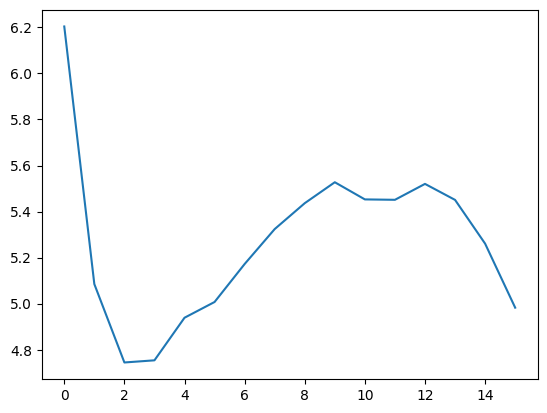

In [12]:
plt.plot(train_losses)

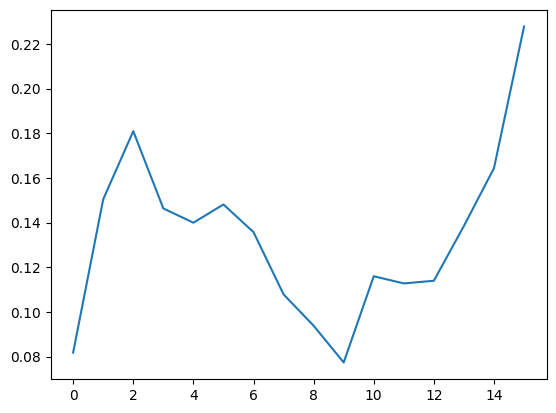

In [14]:
plt.plot(valid_accs)